# 实验准备

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from collections import defaultdict

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from pycocoevalcap.cider.cider import Cider

如果计算机安装有CUDA，则使用CUDA进行接下来的全部训练，否则使用CPU

In [2]:
# 如果计算机安装有CUDA，则使用CUDA进行接下来的全部训练，否则使用CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


查看原始文本和摘要的长度分布

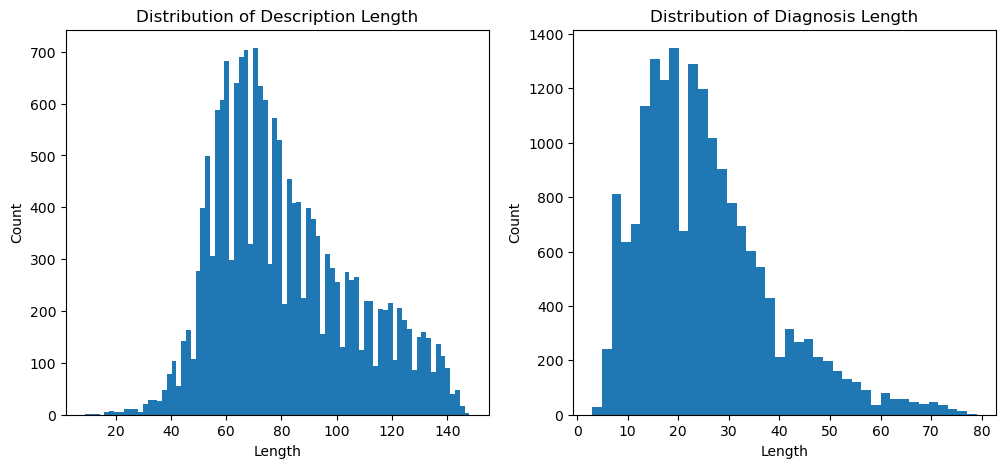

In [3]:
train_set_path = '../data/train.csv'
test_set_path = '../data/test.csv'

train_df = pd.read_csv(train_set_path, index_col=0)
train_description = train_df['description'].str.split()
train_diagnosis = train_df['diagnosis'].str.split()

description_len = [len(sentence) for sentence in train_description]
diagnosis_len = [len(sentence) for sentence in train_diagnosis]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(description_len, bins=80)
plt.title('Distribution of Description Length')
plt.xlabel('Length')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(diagnosis_len, bins=40)
plt.title('Distribution of Diagnosis Length')
plt.xlabel('Length')
plt.ylabel('Count')

fig_path = "../graph/Distribution of Description and Diagnosis Length"
plt.savefig(fig_path)

根据训练数据建立词表

In [4]:
class Vocab:
    def __init__(self, text, min_freq=1, reserved_tokens=None):
        self.idx2token = list()
        self.token2idx = {}
        token_freqs = defaultdict(int)
        self.UNK_TOKEN = '<UNK>'
        
        for sentence in text:
            for token in sentence:
                token_freqs[token] += 1
                
        unique_tokens = [self.UNK_TOKEN]
        if reserved_tokens:
            unique_tokens += reserved_tokens
        # 过滤掉出现频率过低的词
        unique_tokens += [token for token, freq in token_freqs.items() if freq >= min_freq]

        for token in unique_tokens:
            self.idx2token.append(token)
            self.token2idx[token] = len(self.idx2token) - 1
        self.unk = self.token2idx[self.UNK_TOKEN]

    def __len__(self):
        return len(self.idx2token)

    def __getitem__(self, token):
        return self.token2idx.get(token, self.unk)

    def convert_tokens_to_ids(self, tokens):
        return [self[token] for token in tokens]

    def convert_ids_to_tokens(self, ids):
        return [self.idx2token[idx] for idx in ids]

PAD_TOKEN = '<PAD>'
SOS_TOKEN = '<SOS>'
EOS_TOKEN = '<EOS>'
reserved_tokens = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN]
vocab = Vocab(train_description + train_diagnosis, reserved_tokens=reserved_tokens)

划分训练集、验证集、测试集，并转换为Dataloader对象

In [5]:
class DiagnosisDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        description = self.data['description'].str.split()
        diagnosis = self.data['diagnosis'].str.split()
        self.description_ids = [vocab.convert_tokens_to_ids(sentence) for sentence in description]
        self.diagnosis_ids = [[vocab[SOS_TOKEN]] + vocab.convert_tokens_to_ids(sentence) + [vocab[EOS_TOKEN]] for sentence in diagnosis]

    def __len__(self):
        return len(self.description_ids)

    def __getitem__(self, index):
        return self.description_ids[index], self.diagnosis_ids[index]
    
def collate_fn(batch):
    description = [torch.tensor(sample[0]) for sample in batch]
    description_len = torch.tensor([len(sample[0]) for sample in batch])
    padded_description = pad_sequence(description, batch_first=True, padding_value=vocab[PAD_TOKEN])
    
    diagnosis_input = [torch.tensor(sample[1][:-1]) for sample in batch]
    diagnosis_output = [torch.tensor(sample[1][1:]) for sample in batch]
    padded_diagnosis_input = pad_sequence(diagnosis_input, batch_first=True, padding_value=vocab[PAD_TOKEN])
    padded_diagnosis_output = pad_sequence(diagnosis_output, batch_first=True, padding_value=vocab[PAD_TOKEN])
    padding_len = padded_description.size(1) - padded_diagnosis_input.size(1)
    padding = torch.full((padded_diagnosis_input.size(0), padding_len), vocab[PAD_TOKEN])
    padded_diagnosis_input = torch.cat([padded_diagnosis_input, padding], dim=1)
    padded_diagnosis_output = torch.cat([padded_diagnosis_output, padding], dim=1)

    return padded_description, description_len, padded_diagnosis_input, padded_diagnosis_output

train_set_path = '../data/train.csv'
test_set_path = '../data/test.csv'

# 读取训练数据
train_df = pd.read_csv(train_set_path, index_col=0)

# 将训练数据划分为训练集和验证集，固定划分（8:2）
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# 读取测试数据，即测试集
test_df = pd.read_csv(test_set_path, index_col=0)

num_train = train_df.shape[0]
num_val = val_df.shape[0]
num_test = test_df.shape[0]

print('X_train: ', num_train)
print('X_val: ', num_val)
print('X_test: ', num_test)

train_dataset = DiagnosisDataset(train_df)
val_dataset = DiagnosisDataset(val_df)
test_dataset = DiagnosisDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

X_train:  14400
X_val:  3600
X_test:  2000


In [6]:
for description, description_len, diagnosis_input, diagnosis_output in train_loader:
    print(description[0])
    print(type(description[0]))
    print(description_len[0])
    print(type(description_len[0]))
    print(diagnosis_input[0])
    print(type(diagnosis_input[0]))
    print(diagnosis_output[0])
    print(type(diagnosis_output[0]))
    break

tensor([  37,   38,   33,   76,   56,   41,  172,  323,   23,   24,   25,   84,
          38,   39,   40,   41,   18,   46,   41,    7,    9,   14,   15,   42,
        1150,   16,   25,   39,   40,  979,   41,  237,  459,  460,   25,    8,
           9,  172,  209,  267,  155,   25,   41,   51,   34,    6,    8,    9,
          35,   11,   52,   53,   54,   55,   31,   37,   38,  202,   61,   20,
          56,   50,  145,   58,   59,   60,   31,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1])
<class 'torch.Tensor'>
tensor(67)
<class 'torch.Tensor'>
tensor

# 训练并评价模型

In [6]:
class TransformerEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, num_heads=4):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.transformer_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=num_heads
        )
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=num_layers)

    def forward(self, x):
        embedded = self.embedding(x).permute(1, 0, 2)
        output = self.transformer(embedded)
        return output
    
    
class TransformerDecoder(nn.Module):
    def __init__(self, output_size, hidden_size, num_layers=2, num_heads=4):
        super(TransformerDecoder, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.transformer_layer = nn.TransformerDecoderLayer(
            d_model=hidden_size,
            nhead=num_heads
        )
        self.transformer = nn.TransformerDecoder(self.transformer_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, x, memory=None):
        embedded = self.embedding(x).permute(1, 0, 2)
        output = self.transformer(embedded, memory)
        output = self.fc_out(output)
        return output
    
    
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        stdv = 1. / math.sqrt(self.v.size(0))
        self.v.data.uniform_(-stdv, stdv)

    def forward(self, hidden, encoder_outputs):
        timestep = encoder_outputs.size(0)
        h = hidden.repeat(timestep, 1, 1).transpose(0, 1)
        encoder_outputs = encoder_outputs.transpose(0, 1)
        attn_energies = self.score(h, encoder_outputs)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

    def score(self, hidden, encoder_outputs):
        energy = F.tanh(self.attn(torch.cat([hidden, encoder_outputs], 2)))
        energy = energy.transpose(1, 2)
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)
        energy = torch.bmm(v, energy)
        return energy.squeeze(1)

In [7]:
# 定义Seq2Seq模型
class Seq2Seq(nn.Module):
    def __init__(self, input_size, output_size, embed_size, hidden_size, encoder_type, decoder_type):
        super(Seq2Seq, self).__init__()
        self.embedding = nn.Embedding(input_size, embed_size)
        self.encoder_type = encoder_type
        self.decoder_type = decoder_type
        if self.encoder_type == 'rnn':
            self.encoder = nn.RNN(embed_size, hidden_size)
        elif self.encoder_type == 'lstm':
            self.encoder = nn.LSTM(embed_size, hidden_size)
        elif self.encoder_type == 'gru':
            self.encoder = nn.GRU(embed_size, hidden_size)
        elif self.encoder_type == 'transformer':
            self.encoder = TransformerEncoder(input_size, hidden_size)
        if self.decoder_type == 'rnn':
            self.decoder = nn.RNN(embed_size, hidden_size)
        elif self.decoder_type == 'lstm':
            self.decoder = nn.LSTM(embed_size, hidden_size)
        elif self.decoder_type == 'gru':
            self.decoder = nn.GRU(embed_size, hidden_size)
        elif self.decoder_type == 'transformer':
            self.decoder = TransformerDecoder(output_size, hidden_size)
        self.attention = Attention(hidden_size)
        self.fc_out = nn.Linear(2 * hidden_size, output_size)

    def forward(self, input_seq, input_lengths, target_seq, state):
        if self.encoder_type == 'transformer':
            # 编码器处理
            encoder_outputs = self.encoder(input_seq)
            
            if state == 'train':
                # 解码器处理
                output = self.decoder(target_seq, encoder_outputs)

            else:
                output = self.greedy_decode(None, encoder_outputs, input_lengths)
                
        else:
            embedded = self.embedding(input_seq).permute(1, 0, 2)
            encoder_state = torch.zeros(1, len(input_seq), hidden_size).to(device)

            # 编码器处理
            if self.encoder_type == 'lstm':
                encoder_outputs, encoder_state = self.encoder(embedded, (encoder_state, encoder_state))
            else:
                encoder_outputs, encoder_state = self.encoder(embedded, encoder_state)

            # 使用编码器的最后一个隐藏状态初始化解码器
            decoder_state = encoder_state
        
            if state == 'train':
                # 解码器处理
                embedded = self.embedding(target_seq).permute(1, 0, 2)
                decoder_outputs, decoder_states = self.decoder(embedded, decoder_state)
                
                # 使用注意力机制加权平均编码器输出
                if decoder_type == 'lstm':
                    decoder_states = decoder_states[0]
                attn_weights = self.attention(decoder_states, encoder_outputs)
                attn_weights = attn_weights.transpose(1, 2)
                encoder_outputs = encoder_outputs.transpose(0, 1)
                context = encoder_outputs * attn_weights
                decoder_outputs = torch.cat([decoder_outputs, context.transpose(0, 1)], dim=2)
            
                # 输出层
                output = self.fc_out(decoder_outputs)

            else:
                output = self.greedy_decode(encoder_outputs, decoder_state, len(input_lengths))
            
        return output
    
    def greedy_decode(self, encoder_outputs, decoder_state, batch_size, max_len=60):
        # 初始化解码器的输入序列为起始标记 <sos>
        generated_sequences = torch.tensor([[vocab[SOS_TOKEN]]] * batch_size, dtype=torch.long)
        decoder_input = generated_sequences
        
        for _ in range(max_len):
            generated_sequences = generated_sequences.to(device)
            decoder_input = decoder_input.to(device)
            
            # 解码器处理
            if self.decoder_type == 'transformer':
                decoder_output = self.decoder(decoder_input, decoder_state)
            else:
                embedded = self.embedding(decoder_input).permute(1, 0, 2)
                decoder_output, decoder_state = self.decoder(embedded, decoder_state)
                
            # 使用注意力机制加权平均编码器输出
            if decoder_type == 'lstm':
                decoder_states = decoder_state[0]
            else:
                decoder_states = decoder_state
            attn_weights = self.attention(decoder_states, encoder_outputs)
            context = torch.bmm(attn_weights, encoder_outputs.transpose(0, 1))
            decoder_output = torch.cat([decoder_output, context.transpose(0, 1)], dim=2)
                
            # 输出层
            output = self.fc_out(decoder_output)
            
            # 选择概率最高的单词作为下一个输入
            _, predicted_index = output.max(2)
            predicted_token = predicted_index.transpose(0, 1)
            
            # 将预测的单词拼接到目标序列中
            generated_sequences = torch.cat([generated_sequences, predicted_token], dim=1)
            
            if self.decoder_type == 'transformer':
                # 将到当前时间步为止预测的单词作为下一个时间步的输入
                decoder_input = generated_sequences
            else:
                # 将当前时间步预测的单词作为下一个时间步的输入
                decoder_input = predicted_token
                
            # 检查是否生成了结束标记
            if (predicted_token == vocab[EOS_TOKEN]).all():
                break
                
        return generated_sequences.tolist()

In [8]:
# 计算BLEU-4指标
def calculate_bleu_4(generated, reference):
    # 4-gram权重
    weights = [0.25, 0.25, 0.25, 0.25]
    
    # 使用加一平滑
    smoothing_function = SmoothingFunction().method1
    
    score = sentence_bleu([reference], generated, weights=weights, smoothing_function=smoothing_function)
    return score


# 计算ROUGE-2指标
def calculate_rouge_2(generated, reference):
    scorer = rouge_scorer.RougeScorer(['rouge2'])
    scores = scorer.score(' '.join(generated), ' '.join(reference))
    score = scores['rouge2'][0]
    return score


# 计算CIDEr指标
def calculate_cider(generated, reference):
    cider_scorer = Cider()
    score, _ = cider_scorer.compute_score(gts={0: [' '.join(reference)]}, res={0: [' '.join(generated)]})
    return score

In [9]:
# 训练模型
def train_model(model, optimizer, epochs, state='train'):
    model.to(device)
    model.train()
    
    train_loss = []
    for epoch in range(epochs):
        total_loss = 0
        for description, description_len, diagnosis_input, diagnosis_output in train_loader:
            # 将待更新参数的梯度置为零
            optimizer.zero_grad()
            
            description = description.to(device)
            diagnosis_input = diagnosis_input.to(device)
            diagnosis_output = diagnosis_output.to(device)

            output = model(description, description_len, diagnosis_input, state)
            output = output.transpose(0, 1)
            
            loss = 0
            for i in range(len(description_len)):
                loss += F.cross_entropy(output[i], diagnosis_output[i], ignore_index=vocab[PAD_TOKEN])

            # 反向传播，计算梯度
            loss.backward()

            # 利用梯度更新参数
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / num_train
        print(f'Epoch: {epoch + 1}/{epochs}')
        print(f'Train Loss: {avg_loss}')
        train_loss.append(avg_loss)
    
    return model, train_loss

In [10]:
# 评价模型
def evaluate_model(model, loader, num, state):
    model.to(device)
    model.eval()
    
    sum_bleu4 = 0
    sum_rouge2 = 0
    
    with torch.no_grad():
        for description, description_len, diagnosis_input, diagnosis_output in loader:
            description = description.to(device)
            diagnosis_input = diagnosis_input.to(device)
            diagnosis_output = diagnosis_output.to(device)

            predict = model(description, description_len, None, state)
                
            bleu4 = 0
            rouge_2 = 0
            
            for i in range(len(diagnosis_output)):
                eos_index = predict[i].index(vocab[EOS_TOKEN]) if vocab[EOS_TOKEN] in predict[i] else None
                if eos_index is not None:
                    predict_valid = predict[i][:eos_index + 1]
                else:
                    predict_valid = predict[i]
                predict_valid = vocab.convert_ids_to_tokens(predict_valid[1:])
                target_valid = [x for x in diagnosis_output[i] if x != vocab[PAD_TOKEN]]
                target_valid = vocab.convert_ids_to_tokens(target_valid)
                
                bleu4 += calculate_bleu_4(predict_valid, target_valid)
                rouge_2 += calculate_rouge_2(predict_valid, target_valid)

            sum_bleu4 += bleu4
            sum_rouge2 += rouge_2

    avg_bleu4 = sum_bleu4 / num
    avg_rouge2 = sum_rouge2 / num
    
    print('BLEU-4: ', avg_bleu4)
    print('ROUGE-2: ', avg_rouge2)
    
    return avg_bleu4, avg_rouge2

In [11]:
train_loss_all = dict()

In [12]:
# RNN as encoder
learning_rate = 1e-3
vocab_size = len(vocab)
embed_size = 256
hidden_size = 512
encoder_types = ['rnn']
decoder_types = ['rnn', 'gru']

for encoder_type in encoder_types:
    for decoder_type in decoder_types:
        model = Seq2Seq(vocab_size, vocab_size, embed_size, hidden_size, encoder_type, decoder_type)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        model, train_loss = train_model(model, optimizer, epochs=50)
        key = encoder_type.upper() + '/' + decoder_type.upper()
        train_loss_all[key] = train_loss
        print('Encoder: ', encoder_type.upper(), ', Decoder: ', decoder_type.upper())
        print('Validation:')
        val_bleu4, val_rouge2 = evaluate_model(model, val_loader, num_val, 'val')
        print('Test:')
        test_bleu4, test_rouge2 = evaluate_model(model, test_loader, num_test, 'test')

Epoch: 1/50
Train Loss: 2.5031433370378284
Epoch: 2/50
Train Loss: 1.922599048614502
Epoch: 3/50
Train Loss: 1.8170295815997655
Epoch: 4/50
Train Loss: 1.72526319609748
Epoch: 5/50
Train Loss: 1.656874811914232
Epoch: 6/50
Train Loss: 1.6033730263180204
Epoch: 7/50
Train Loss: 1.5468736378351848
Epoch: 8/50
Train Loss: 1.4984448856777615
Epoch: 9/50
Train Loss: 1.4593386475245158
Epoch: 10/50
Train Loss: 1.414776210784912
Epoch: 11/50
Train Loss: 1.3750838369793361
Epoch: 12/50
Train Loss: 1.3351859362920124
Epoch: 13/50
Train Loss: 1.2993352460861205
Epoch: 14/50
Train Loss: 1.2630780034595066
Epoch: 15/50
Train Loss: 1.2294935364193387
Epoch: 16/50
Train Loss: 1.1984873957104154
Epoch: 17/50
Train Loss: 1.170184981558058
Epoch: 18/50
Train Loss: 1.1417648137940302
Epoch: 19/50
Train Loss: 1.1164860616789924
Epoch: 20/50
Train Loss: 1.0908043893178303
Epoch: 21/50
Train Loss: 1.0730341251691182
Epoch: 22/50
Train Loss: 1.0519689016871983
Epoch: 23/50
Train Loss: 1.0357907274034288
Epo

In [ ]:
# LSTM as encoder
learning_rate = 1e-3
vocab_size = len(vocab)
embed_size = 256
hidden_size = 512
encoder_types = ['lstm']
decoder_types = ['lstm']

for encoder_type in encoder_types:
    for decoder_type in decoder_types:
        model = Seq2Seq(vocab_size, vocab_size, embed_size, hidden_size, encoder_type, decoder_type)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        model, train_loss = train_model(model, optimizer, epochs=50)
        key = encoder_type.upper() + '/' + decoder_type.upper()
        train_loss_all[key] = train_loss
        print('Encoder: ', encoder_type.upper(), ', Decoder: ', decoder_type.upper())
        print('Validation:')
        val_bleu4, val_rouge2 = evaluate_model(model, val_loader, num_val, 'val')
        print('Test:')
        test_bleu4, test_rouge2 = evaluate_model(model, test_loader, num_test, 'test')

Epoch: 1/50
Train Loss: 2.7286920229593914
Epoch: 2/50
Train Loss: 1.9365879906548393
Epoch: 3/50
Train Loss: 1.7924682897991604
Epoch: 4/50
Train Loss: 1.6957670497894286
Epoch: 5/50
Train Loss: 1.6169587887658012
Epoch: 6/50
Train Loss: 1.5492746973037719
Epoch: 7/50
Train Loss: 1.4864619376924302
Epoch: 8/50
Train Loss: 1.4269667185677422
Epoch: 9/50
Train Loss: 1.3701656770706176
Epoch: 10/50
Train Loss: 1.3143878449334039
Epoch: 11/50
Train Loss: 1.2584626669353909
Epoch: 12/50
Train Loss: 1.203171067767673
Epoch: 13/50
Train Loss: 1.1501905515458848
Epoch: 14/50
Train Loss: 1.0956276581022475
Epoch: 15/50
Train Loss: 1.042903594970703
Epoch: 16/50
Train Loss: 0.991061127450731
Epoch: 17/50
Train Loss: 0.9402818332778083
Epoch: 18/50
Train Loss: 0.8931535124778748
Epoch: 19/50
Train Loss: 0.8465089739693535
Epoch: 20/50
Train Loss: 0.8021498613887363
Epoch: 21/50
Train Loss: 0.7602953253851996
Epoch: 22/50
Train Loss: 0.7195046485794915
Epoch: 23/50
Train Loss: 0.6822104779879252


In [14]:
# GRU as encoder
learning_rate = 1e-3
vocab_size = len(vocab)
embed_size = 256
hidden_size = 512
encoder_types = ['gru']
decoder_types = ['rnn', 'gru']

for encoder_type in encoder_types:
    for decoder_type in decoder_types:
        model = Seq2Seq(vocab_size, vocab_size, embed_size, hidden_size, encoder_type, decoder_type)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        model, train_loss = train_model(model, optimizer, epochs=50)
        key = encoder_type.upper() + '/' + decoder_type.upper()
        train_loss_all[key] = train_loss
        print('Encoder: ', encoder_type.upper(), ', Decoder: ', decoder_type.upper())
        print('Validation:')
        val_bleu4, val_rouge2 = evaluate_model(model, val_loader, num_val, 'val')
        print('Test:')
        test_bleu4, test_rouge2 = evaluate_model(model, test_loader, num_test, 'test')

Epoch: 1/50
Train Loss: 2.4575028642018637
Epoch: 2/50
Train Loss: 1.857778288523356
Epoch: 3/50
Train Loss: 1.7216602532068888
Epoch: 4/50
Train Loss: 1.627227366235521
Epoch: 5/50
Train Loss: 1.5464926804436578
Epoch: 6/50
Train Loss: 1.4750618886947633
Epoch: 7/50
Train Loss: 1.4128003205193413
Epoch: 8/50
Train Loss: 1.348597387207879
Epoch: 9/50
Train Loss: 1.2903423690795899
Epoch: 10/50
Train Loss: 1.2336942609151205
Epoch: 11/50
Train Loss: 1.180482296678755
Epoch: 12/50
Train Loss: 1.12897778140174
Epoch: 13/50
Train Loss: 1.0792486566967434
Epoch: 14/50
Train Loss: 1.032588905758328
Epoch: 15/50
Train Loss: 0.9872618823581272
Epoch: 16/50
Train Loss: 0.9496747451358372
Epoch: 17/50
Train Loss: 0.9087144017219544
Epoch: 18/50
Train Loss: 0.8719814893934462
Epoch: 19/50
Train Loss: 0.8369811868667603
Epoch: 20/50
Train Loss: 0.8058833935525682
Epoch: 21/50
Train Loss: 0.7753814045588175
Epoch: 22/50
Train Loss: 0.7503813362121582
Epoch: 23/50
Train Loss: 0.7252636528015137
Epoc

In [18]:
# Transformer as encoder
learning_rate = 1e-3
vocab_size = len(vocab)
embed_size = 64
hidden_size = 128
encoder_types = ['transformer']
decoder_types = ['transformer']

for encoder_type in encoder_types:
    for decoder_type in decoder_types:
        model = Seq2Seq(vocab_size, vocab_size, embed_size, hidden_size, encoder_type, decoder_type)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        model, train_loss = train_model(model, optimizer, epochs=50)
        key = 'Transformer/Transformer'
        train_loss_all[key] = train_loss
        '''
        print('Encoder: ', encoder_type.upper(), ', Decoder: ', decoder_type.upper())
        print('Validation:')
        val_bleu4, val_rouge2, val_cider = evaluate_model(model, val_loader, num_val, 'val')
        print('Test:')
        test_bleu4, test_rouge2, test_cider = evaluate_model(model, test_loader, num_test, 'test')
        '''

Epoch: 1/50
Train Loss: 2.6154591703414916
Epoch: 2/50
Train Loss: 1.7349687438540988
Epoch: 3/50
Train Loss: 1.5244566000832451
Epoch: 4/50
Train Loss: 1.3971418868170844
Epoch: 5/50
Train Loss: 1.3015514458550348
Epoch: 6/50
Train Loss: 1.2273244794209799
Epoch: 7/50
Train Loss: 1.1626888614230686
Epoch: 8/50
Train Loss: 1.107355739540524
Epoch: 9/50
Train Loss: 1.056741390493181
Epoch: 10/50
Train Loss: 1.0124701952934265
Epoch: 11/50
Train Loss: 0.9654278371069166
Epoch: 12/50
Train Loss: 0.923717221154107
Epoch: 13/50
Train Loss: 0.8869251200887892
Epoch: 14/50
Train Loss: 0.8572756022877164
Epoch: 15/50
Train Loss: 0.8255496046278212
Epoch: 16/50
Train Loss: 0.7987890224986606
Epoch: 17/50
Train Loss: 0.7735358272658454
Epoch: 18/50
Train Loss: 0.7510839941766527
Epoch: 19/50
Train Loss: 0.7303788492414687
Epoch: 20/50
Train Loss: 0.7123697598775228
Epoch: 21/50
Train Loss: 0.6981799448861016
Epoch: 22/50
Train Loss: 0.6788930062452952
Epoch: 23/50
Train Loss: 0.6667594590451982


# 绘制图像

In [22]:
# 绘制训练损失变化图
def plot_train_loss(train_loss, path):
    model_type = ['RNN/RNN', 'RNN/GRU', 'LSTM/LSTM', 'GRU/RNN', 'GRU/GRU', 'Transformer/Transformer']
    epoch = np.arange(1, 51)
    
    for i in range(len(model_type)):
        plt.plot(epoch, train_loss[model_type[i]], label=model_type[i])
    
    plt.legend()
    plt.title('Train Loss for Different Seq2Seq Architectures')
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.savefig(path)

In [18]:
# 绘制各模型在验证集或测试集上的评估指标图
def plot_evaluation_indices(validation_index_values, test_index_values, ylabel, path):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    model_type = ['RNN/RNN', 'RNN/GRU', 'LSTM/LSTM', 'GRU/RNN', 'GRU/GRU', 'BART']
    
    validation_mean = np.mean(validation_index_values, axis=1)
    validation_std = np.std(validation_index_values, axis=1)
    axs[0].errorbar(model_type, validation_mean, yerr=validation_std, fmt='o-')
    
    axs[0].set_xlabel('Model Type')
    axs[0].set_ylabel(ylabel)
    axs[0].set_title('Validation')
    
    test_mean = np.mean(test_index_values, axis=1)
    test_std = np.std(test_index_values, axis=1)
    axs[1].errorbar(model_type, test_mean, yerr=test_std, fmt='o-')
    
    axs[1].set_xlabel('Model Type')
    axs[1].set_ylabel(ylabel)
    axs[1].set_title('Test')
        
    plt.tight_layout()
    plt.savefig(path)

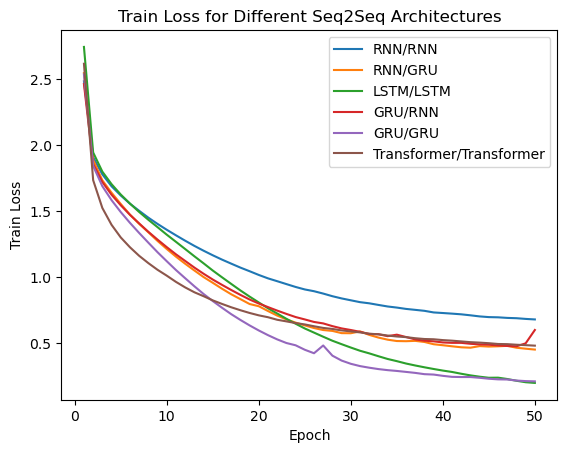

In [24]:
fig1_path = "../graph/Train Loss for Different Seq2Seq Architectures.png"
plot_train_loss(train_loss_all, fig1_path)

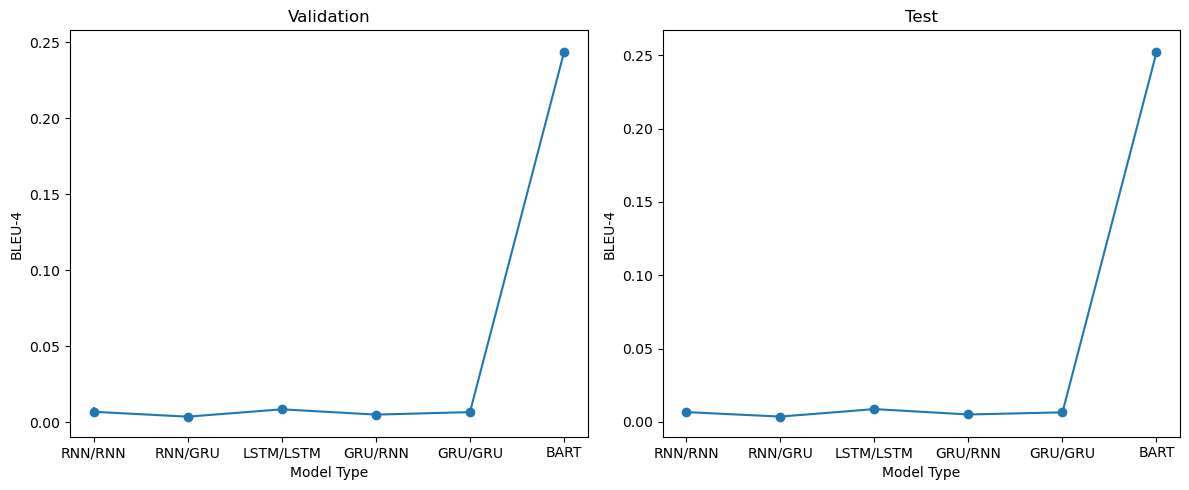

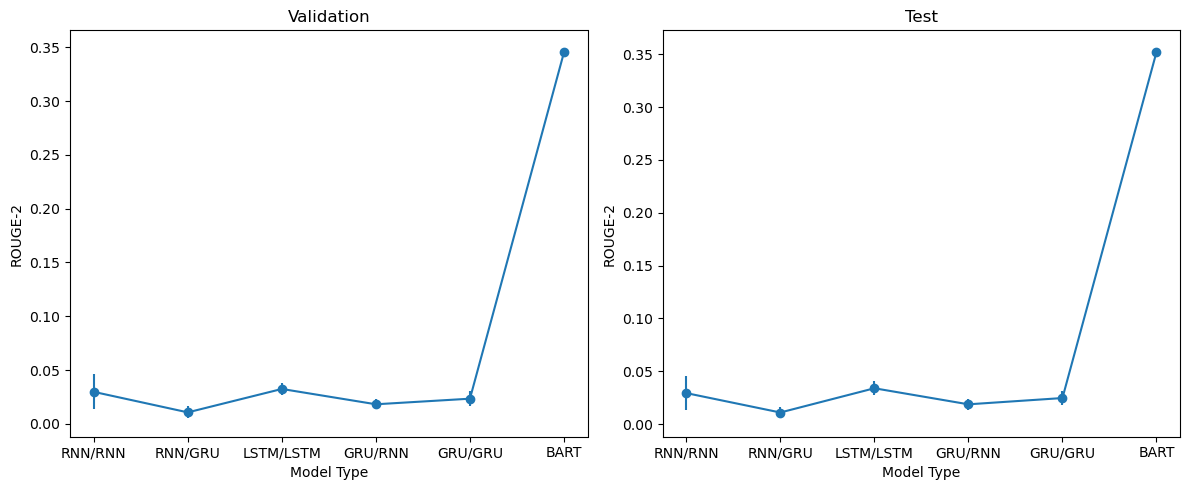

In [19]:
val_bleu4 = np.array([[0.0054, 0.0083, 0.0033, 0.0050, 0.0117],
                      [0.0031, 0.0055, 0.0033, 0.0034, 0.0024],
                      [0.0077, 0.0087, 0.0099, 0.0090, 0.0066],
                      [0.0052, 0.0055, 0.0049, 0.0034, 0.0055],
                      [0.0080, 0.0091, 0.0059, 0.0048, 0.0049],
                      [0.2452, 0.2404, 0.2452, 0.2404, 0.2452]])
test_bleu4 = np.array([[0.0053, 0.0081, 0.0036, 0.0049, 0.0117],
                       [0.0032, 0.0058, 0.0034, 0.0035, 0.0024],
                       [0.0075, 0.0092, 0.0103, 0.0099, 0.0069],
                       [0.0057, 0.0055, 0.0050, 0.0035, 0.0058],
                       [0.0076, 0.0089, 0.0062, 0.0055, 0.0045],
                       [0.2540, 0.2490, 0.2540, 0.2490, 0.2540]])

fig2_path = "../graph/BLEU-4 for Different Seq2Seq Architectures.png"
plot_evaluation_indices(val_bleu4, test_bleu4, 'BLEU-4', fig2_path)

val_rouge2 = np.array([[0.0199, 0.0415, 0.0113, 0.0205, 0.0555],
                       [0.0099, 0.0210, 0.0082, 0.0095, 0.0048],
                       [0.0296, 0.0373, 0.0389, 0.0321, 0.0243],
                       [0.0200, 0.0206, 0.0186, 0.0095, 0.0223],
                       [0.0287, 0.0344, 0.0217, 0.0159, 0.0163],
                       [0.3480, 0.3413, 0.3480, 0.3413, 0.3480]])
test_rouge2 = np.array([[0.0206, 0.0395, 0.0120, 0.0194, 0.0550],
                        [0.0102, 0.0211, 0.0096, 0.0091, 0.0047],
                        [0.0291, 0.0391, 0.0419, 0.0352, 0.0241],
                        [0.0216, 0.0211, 0.0190, 0.0091, 0.0226],
                        [0.0296, 0.0354, 0.0228, 0.0190, 0.0163],
                        [0.3545, 0.3482, 0.3545, 0.3482, 0.3545]])

fig3_path = "../graph/ROUGE-2 for Different Seq2Seq Architectures.png"
plot_evaluation_indices(val_rouge2, test_rouge2, 'ROUGE-2', fig3_path)